# Autoencoder
This notebook makes use of the **Autoencoder**, which is used to reduce the dimensionality of our dataset in a non-linear way. Furthermore, we then apply **k-means Clustering** as in our last notebook in our new created **Latent Space** in lower dimension. We do so, to get rid of less important variables and achieve a better Clustering.

In [5]:
# !pip install cartopy xarray matplotlib netCDF4 torch

In [6]:
import helper_functions
import importlib
from ipywidgets import FloatSlider
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from ipywidgets import interact, IntSlider
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader, TensorDataset

## Data Loading & Preprocessing

In [7]:
ds = xr.open_dataset("/home/jovyan/spatiotemporal-mining-medsea/data/medsea.nc")

def preprocessing(features: list, depths: list, dim):
    """
    feature: List of features to combine. "sol" for Salinity or "temperature for Temperature.
    depth: "Any value from 0 to 1062, but it will assign the closest existing."

    returns a stacked array of the "feature".
    """

    def standardize(group):
        m = group.mean("time")
        s = group.std("time")
        return (group - m) / s

    feature_vectors = []
    for feature in features:

        for depth in depths:
            data = ds[feature].sel(depth=depth, method="nearest")
            data = data.assign_coords(month=data["time"].dt.month)
        
            z = data.groupby("month").apply(standardize)
            z = z.stack(location=("latitude", "longitude"))
            feature_vectors.append(z)
    
    z_concat = xr.concat(feature_vectors, dim=dim)
    z_concat = z_concat.dropna(dim="location", how="any")

    return z_concat  # → xarray.DataArray mit dims: ("time", "location")

In [8]:
z_temp = preprocessing(["thetao", "so"], [50, 300, 1000], "location")
X = z_temp.values
print(X.shape)
input_dimension = X.shape[1]
print(z_temp.nbytes / 1e6, "MB")

(342, 194294)
531.588384 MB


## Splitting

In [5]:
X = X.astype(np.float32)
X_train, X_test = train_test_split(X, test_size=0.1, random_state=27)

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train)), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test)), batch_size=32, shuffle=False)

## The Architecture

In [6]:
# class Autoencoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super().__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, 512),
#             nn.ReLU(),
#             nn.Dropout(p=0.15),
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(p=0.15),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(p=0.15),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(p=0.15),
#             nn.Linear(64, latent_dim),
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, 64),
#             nn.ReLU(),
#             nn.Linear(64, 128),
#             nn.ReLU(),
#             nn.Linear(128, 256),
#             nn.ReLU(),
#             nn.Linear(256, 512),
#             nn.ReLU(),
#             nn.Linear(512, input_dim)
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         return self.decoder(z)

In [7]:
import torch
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            nn.Linear(256, latent_dim)
            # Kein ReLU hier – das Latent kann auch negativ sein
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, input_dim)
            # KEINE Aktivierungsfunktion hier – du willst rekonstruieren, nicht beschneiden
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


## Training Loop

## Loss & Setup

In [8]:
def train(num_epochs: int):
    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for batch in train_loader:
            x = batch[0].to(device).float()
                    
            optimizer.zero_grad()
            x_recon = model(x)
            loss = loss_fn(x_recon, x)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * x.size(0)
    
        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                x = batch[0].to(device).float()
                x_recon = model(x)
                loss = loss_fn(x_recon, x)
                running_val_loss += loss.item() * x.size(0)
    
        val_loss = running_val_loss / len(test_loader.dataset)
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses

In [9]:
model = Autoencoder(input_dim=input_dimension, latent_dim=3)
model = model.float()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Training using device: {device}')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 50

train_losses, val_losses = train(num_epochs)

Training using device: cuda
Epoch 1/50 | Train Loss: 0.9266 | Val Loss: 0.8684
Epoch 2/50 | Train Loss: 0.7174 | Val Loss: 0.7241
Epoch 3/50 | Train Loss: 0.6737 | Val Loss: 0.6523
Epoch 4/50 | Train Loss: 0.6321 | Val Loss: 0.6201
Epoch 5/50 | Train Loss: 0.5963 | Val Loss: 0.5966
Epoch 6/50 | Train Loss: 0.5851 | Val Loss: 0.5869
Epoch 7/50 | Train Loss: 0.5643 | Val Loss: 0.5797
Epoch 8/50 | Train Loss: 0.5588 | Val Loss: 0.5749
Epoch 9/50 | Train Loss: 0.5518 | Val Loss: 0.5611
Epoch 10/50 | Train Loss: 0.5477 | Val Loss: 0.5529
Epoch 11/50 | Train Loss: 0.5251 | Val Loss: 0.5470
Epoch 12/50 | Train Loss: 0.5341 | Val Loss: 0.5459
Epoch 13/50 | Train Loss: 0.5022 | Val Loss: 0.5357
Epoch 14/50 | Train Loss: 0.5175 | Val Loss: 0.5296
Epoch 15/50 | Train Loss: 0.5084 | Val Loss: 0.5241
Epoch 16/50 | Train Loss: 0.5045 | Val Loss: 0.5169
Epoch 17/50 | Train Loss: 0.5065 | Val Loss: 0.5123
Epoch 18/50 | Train Loss: 0.4814 | Val Loss: 0.5115
Epoch 19/50 | Train Loss: 0.4905 | Val Loss: 

## Evaluation

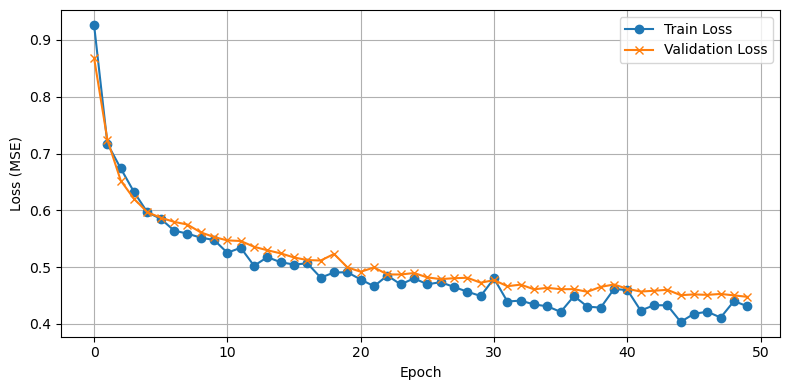

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Clustering with K-Means

### Clustering the reconstructions

### Latent = 42

In [11]:
importlib.reload(helper_functions)

<module 'helper_functions' from '/home/jovyan/spatiotemporal-mining-medsea/notebooks/helper_functions.py'>

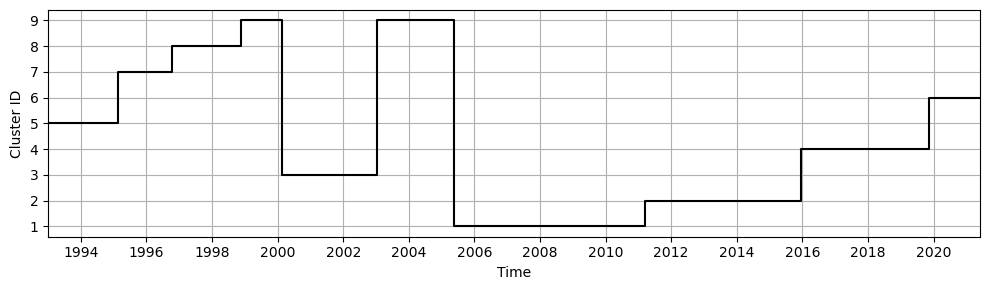

In [12]:
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    X_recon_all = model(X_tensor).cpu().numpy()

k=9
labels = helper_functions.apply_kmeans(X_recon_all, k)
labels += 1

helper_functions.plot_cluster_timeline(z_temp, labels)

### Depth = 50

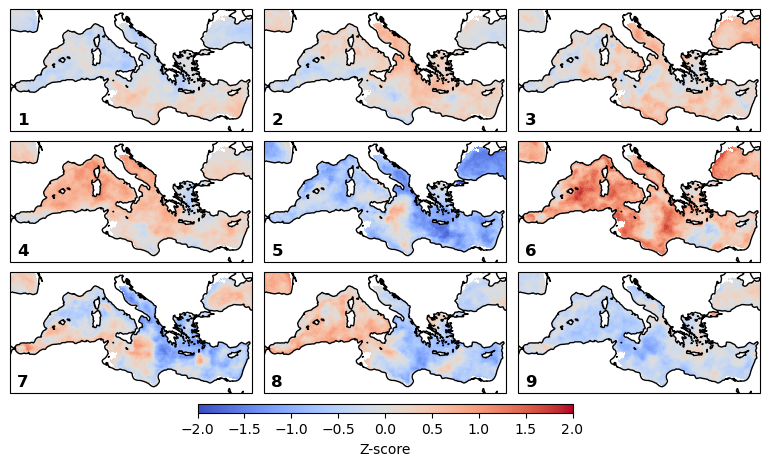

In [13]:
recon_temp_50 = helper_functions.reconstructed_to_stack(ds, "thetao", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

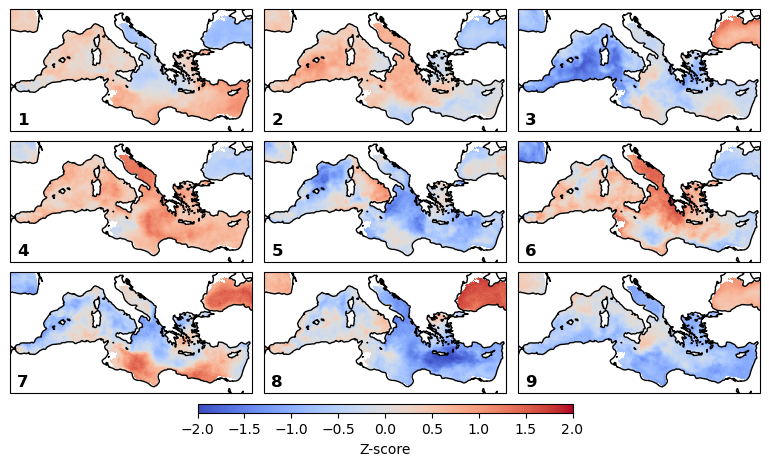

In [20]:
recon_so_50 = helper_functions.reconstructed_to_stack(ds, "so", 50, X_recon_all)
helper_functions.plot_average_cluster(recon_so_50, labels, -2, 2)

### Depth = 300

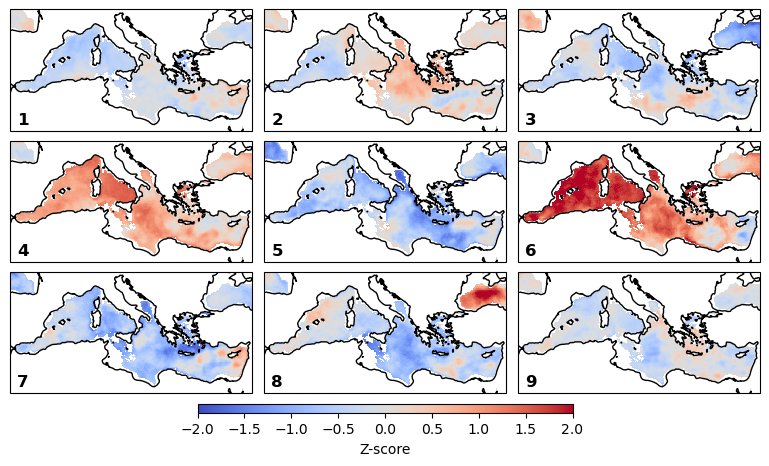

In [15]:
recon_temp_300 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_300, labels, -2, 2)

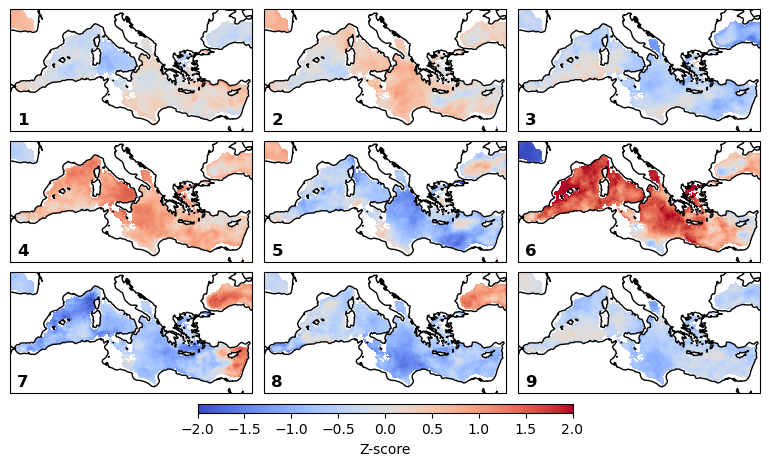

In [16]:
recon_so_300 = helper_functions.reconstructed_to_stack(ds, "so", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_so_300, labels, -2, 2)

### Depth = 1000

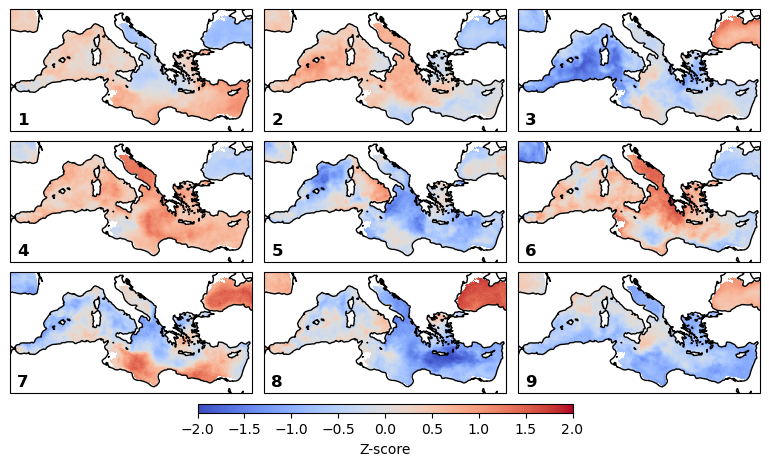

In [17]:
recon_temp_1000 = helper_functions.reconstructed_to_stack(ds, "thetao", 300, X_recon_all)
helper_functions.plot_average_cluster(recon_temp_50, labels, -2, 2)

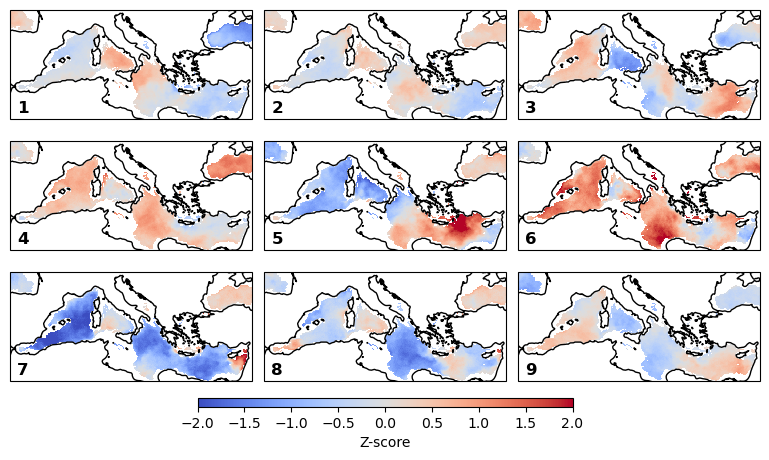

In [18]:
recon_so_1000 = helper_functions.reconstructed_to_stack(ds, "so", 1000, X_recon_all)
helper_functions.plot_average_cluster(recon_so_1000, labels, -2, 2)

### Latent clustering

In [19]:
# import numpy as np
# import torch
# from sklearn.cluster import KMeans

# def encode_latents(model, X, batch_size=128):
#     """
#     X: NumPy array (n_samples, n_features)
#     model: trained autoencoder
#     returns: (n_samples, latent_dim)
#     """
#     model.eval()
#     latents = []

#     with torch.no_grad():
#         for i in range(0, len(X), batch_size):
#             batch = X[i:i+batch_size]
#             batch = torch.tensor(batch, dtype=torch.float32).to(device)
#             z = model.encoder(batch)
#             latents.append(z.cpu().numpy())

#     return np.concatenate(latents, axis=0)

# # 1. Latents berechnen
# latents_train = encode_latents(model, X_train)
# latents_test = encode_latents(model, X_test)
# latents_all = np.vstack([latents_train, latents_test])
# # 2. Clustering mit KMeans
# k = 9  # z.B. 5 Cluster
# kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
# labels = kmeans.fit_predict(latents_all)
# labels += 1


# helper_functions.plot_cluster_timeline(z_temp, labels)

# plot_cluster_average_reconstructions(
#     model=model,
#     X=np.vstack([X_train, X_test]),
#     labels=labels,
#     z_stack=z_stack,
#     num_clusters=k,
#     device=device
# )